In [1]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

/Users/priyambasu/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/priyambasu/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/priyambasu/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/priyambasu/Library/Python/3.7/lib/python/s

In [3]:
#Preventing any unnecessary verbose from popping up
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
#Getting the current directory of this iPynb file
os.getcwd()

'/Users/priyambasu/Desktop/sarcasm_bilst'

In [10]:
#loading the dataset, from the json file stored in the given directory below, and visualising it
data=pd.read_json("data/Sarcasm_Headlines_Dataset.json",lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
#Removing the link, and putting the organisation in its place
import re
data["organization"]=data["article_link"].apply(lambda x: re.findall(r"\w+",x)[2])
data=data.drop(["article_link"],axis=1)
data.head()

,headline,is_sarcastic,organization
0,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,mom starting to fear son's web series closest ...,1,theonion
3,"boehner just wants wife to listen, not come up...",1,theonion
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
headline        26709 non-null object
is_sarcastic    26709 non-null int64
organization    26709 non-null object
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [13]:
data.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


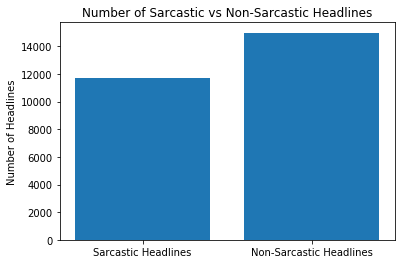

In [15]:
#Visualization
sarcastic=0
for i in range(len(data["is_sarcastic"])):
    if data["is_sarcastic"].iloc[i]==1:
        sarcastic+=1
normal=len(data["is_sarcastic"])-sarcastic
label_values={"Sarcastic Headlines" : sarcastic, "Non-Sarcastic Headlines" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.title("Number of Sarcastic vs Non-Sarcastic Headlines")
plt.ylabel("Number of Headlines")
plt.show()

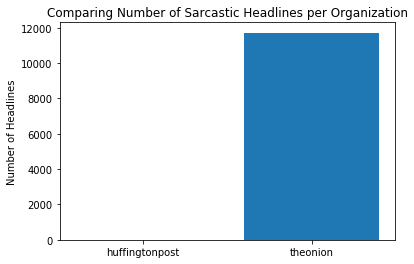

In [16]:
#Now, to ignore the effect of the organization on whether a headline is sarcastic, we need to check for skew
#list(data["organization"].unique()) returns only two organizations 'huffingtonpost' and 'theonion'
org_labels={"huffingtonpost" : 0, "theonion" : 0}
for i in range(len(data["organization"])):
    if data["is_sarcastic"].iloc[i]==1:
        org_labels[data["organization"].iloc[i]]+=1
plt.bar(org_labels.keys(),org_labels.values(),align="center")
plt.title("Comparing Number of Sarcastic Headlines per Organization")
plt.ylabel("Number of Headlines")
plt.show()

In [17]:
#Dropping the "organization" column
data=data.drop(["organization"],axis=1)
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["headline"]))
X=tokenizer.texts_to_sequences(list(data["headline"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["is_sarcastic"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 29656
The shape of the trainable data : (26709, 300)
The shape of the labels for the data is : (26709, 2)


In [19]:
#Getting the pre trained GloVe embeddings into the embedding matrix from the link used in this cell
embedding_words={}
file=open("glove.6B.300d.txt")
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


In [20]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [21]:
#Creating the embedding layer further with the help of keras
#These embeddings are made non-trainable as they are pre trained to highly optimized values
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
#Getting the shape of the embedding matrix (should be (num_words,embedding_dim)=(20000,300))
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))


The shape of the embedding matrix is (20000, 300)


In [22]:
#Building the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Flatten())
model.add(Dense(30,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
#Splittting the data into training and testing sets before fitting the model
#Using a 80% - 20% split for the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [24]:
batch_size=128 #Using a batch size of 128, during gradient descent
num_epochs=10 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))


Train on 21367 samples, validate on 5342 samples
Epoch 1/10
21367/21367 [==============================] - 265s 12ms/step - loss: 0.5479 - acc: 0.7199 - val_loss: 0.4164 - val_acc: 0.8080
Epoch 2/10
21367/21367 [==============================] - 241s 11ms/step - loss: 0.4347 - acc: 0.8072 - val_loss: 0.3675 - val_acc: 0.8343
Epoch 3/10
21367/21367 [==============================] - 270s 13ms/step - loss: 0.3961 - acc: 0.8287 - val_loss: 0.3605 - val_acc: 0.8415
Epoch 4/10
21367/21367 [==============================] - 263s 12ms/step - loss: 0.3630 - acc: 0.8431 - val_loss: 0.3440 - val_acc: 0.8477
Epoch 5/10
21367/21367 [==============================] - 258s 12ms/step - loss: 0.3481 - acc: 0.8508 - val_loss: 0.3548 - val_acc: 0.8418
Epoch 6/10
21367/21367 [==============================] - 254s 12ms/step - loss: 0.3339 - acc: 0.8573 - val_loss: 0.3485 - val_acc: 0.8485
Epoch 7/10
21367/21367 [==============================] - 284s 13ms/step - loss: 0.3215 - acc: 0.8642 - val_loss: 0.3

In [36]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))


5342/5342 [==============================] - 18s 3ms/step
The loss of the model on the test set : 0.33913332241186706
The accuracy of the model on the test set : 84.6873830048523%


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 149, 256)          164864    
_________________________________________________________________
flatten_1 (Flatten)          (None, 38144)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1144350   
__________

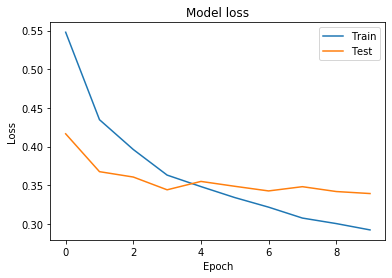

In [38]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

In [44]:
#Saving the model to the disk
model_json = model.to_json()
with open("model_sarcasmdetection.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_sarcasmdetection.h5")